In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.optimized_search import OptimizedSearch
import evaluation_metrics

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
# Functions specific to this file
def save_results(scores, acc_drop, opt_params, num):
    
    with open(output_path + f'opt_params_{num}.p', 'wb') as f:
        pickle.dump(opt_params, f)
    
    with open(output_path + f'acc_drop_{num}.p', 'wb') as f:
        pickle.dump(acc_drop, f)
    
    with open(output_path + f'scores_{num}.p', 'wb') as f:
        pickle.dump(scores, f)

In [3]:
input_shape = (28, 28, 1)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_seq_large_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Comp_Dependent_Optimized_Search/Sequential MNIST/'
name = 'mnist_seq_large'
total_acc_drop = 0.005

from test_models.mnist_custom import data
_, (x_test, y_test) = data.get_data()

test_data = []
for i in range(4):
    test_data.append((x_test[int(i*len(x_test)/4):int((i + 1) * len(x_test)/4), :, :, :], 
                        y_test[int(i*len(y_test)/4): int((i + 1) * len(y_test)/4), :]))

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
t_d = test_data[0]
model_obj = model_data.Model(name, t_d, model=model_arch.get_float_model())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
layer_names = [layer.name for layer in model_obj.model.layers if layer.name.startswith('conv2d') or \
               layer.name.startswith('dense')]
print(layer_names)

['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'dense_1']


### Budget allocation

In [5]:
linear = lambda x, total_acc_drop, num_layers, offset=0: total_acc_drop/num_layers * x + offset

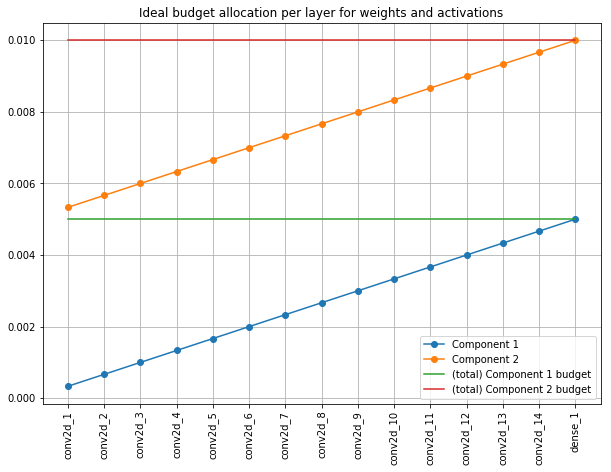

In [6]:
x = np.arange(1, len(layer_names) + 1)
plt.figure(figsize=(10, 7));
plt.title('Ideal budget allocation per layer for weights and activations');
y1 = linear(x, total_acc_drop, len(layer_names))
y2 = linear(x, total_acc_drop, len(layer_names), total_acc_drop)
plt.plot(x, y1, 'o-', label='Component 1');
plt.plot(x, y2, 'o-', label='Component 2');
plt.xticks(x, layer_names, rotation='vertical')
plt.plot(x, np.ones(y2.shape) * total_acc_drop, label='(total) Component 1 budget');
plt.plot(x, np.ones(y2.shape) * total_acc_drop*2, label='(total) Component 2 budget')
plt.grid();
plt.legend();

# Weights (& Biases) - Activations

#### Weights

In [7]:
t_d = test_data[0]
model_obj = model_data.Model(name, t_d, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

0.9912


{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 14], 'conv2d_8': [12, 14], 'conv2d_9': [12, 14], 'conv2d_10': [12, 14], 'conv2d_11': [12, 14], 'conv2d_12': [12, 14], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Quantizing layer conv2d_1
Global opt: (5, 6) Local opt: (5, 6) Performance diff: 0.000000
Chosen:  (5, 6)
After quantizing weights of layer conv2d_1 | Measured accuracy drop -0.000807 | Acceptable accuracy drop: 0.000333
Quantizing layer conv2d_2
Global opt: (3, 5) Local opt: (4, 6) Performance diff: 0.000404
Chosen:  (3, 5)
After quantizing weights of layer conv2d_2 | Measured accuracy drop 0.000000 | Acceptable accuracy drop: 0.000667
Quantizing layer conv2d_3
Global opt: (2, 3) Local opt: (2, 3) Performance diff: 0.000000
Chosen:  (2, 3)
After quantizing weights of layer conv2d_3 | Measured accuracy drop 0.000807 | Acceptable accuracy drop: 0.001000
Quan

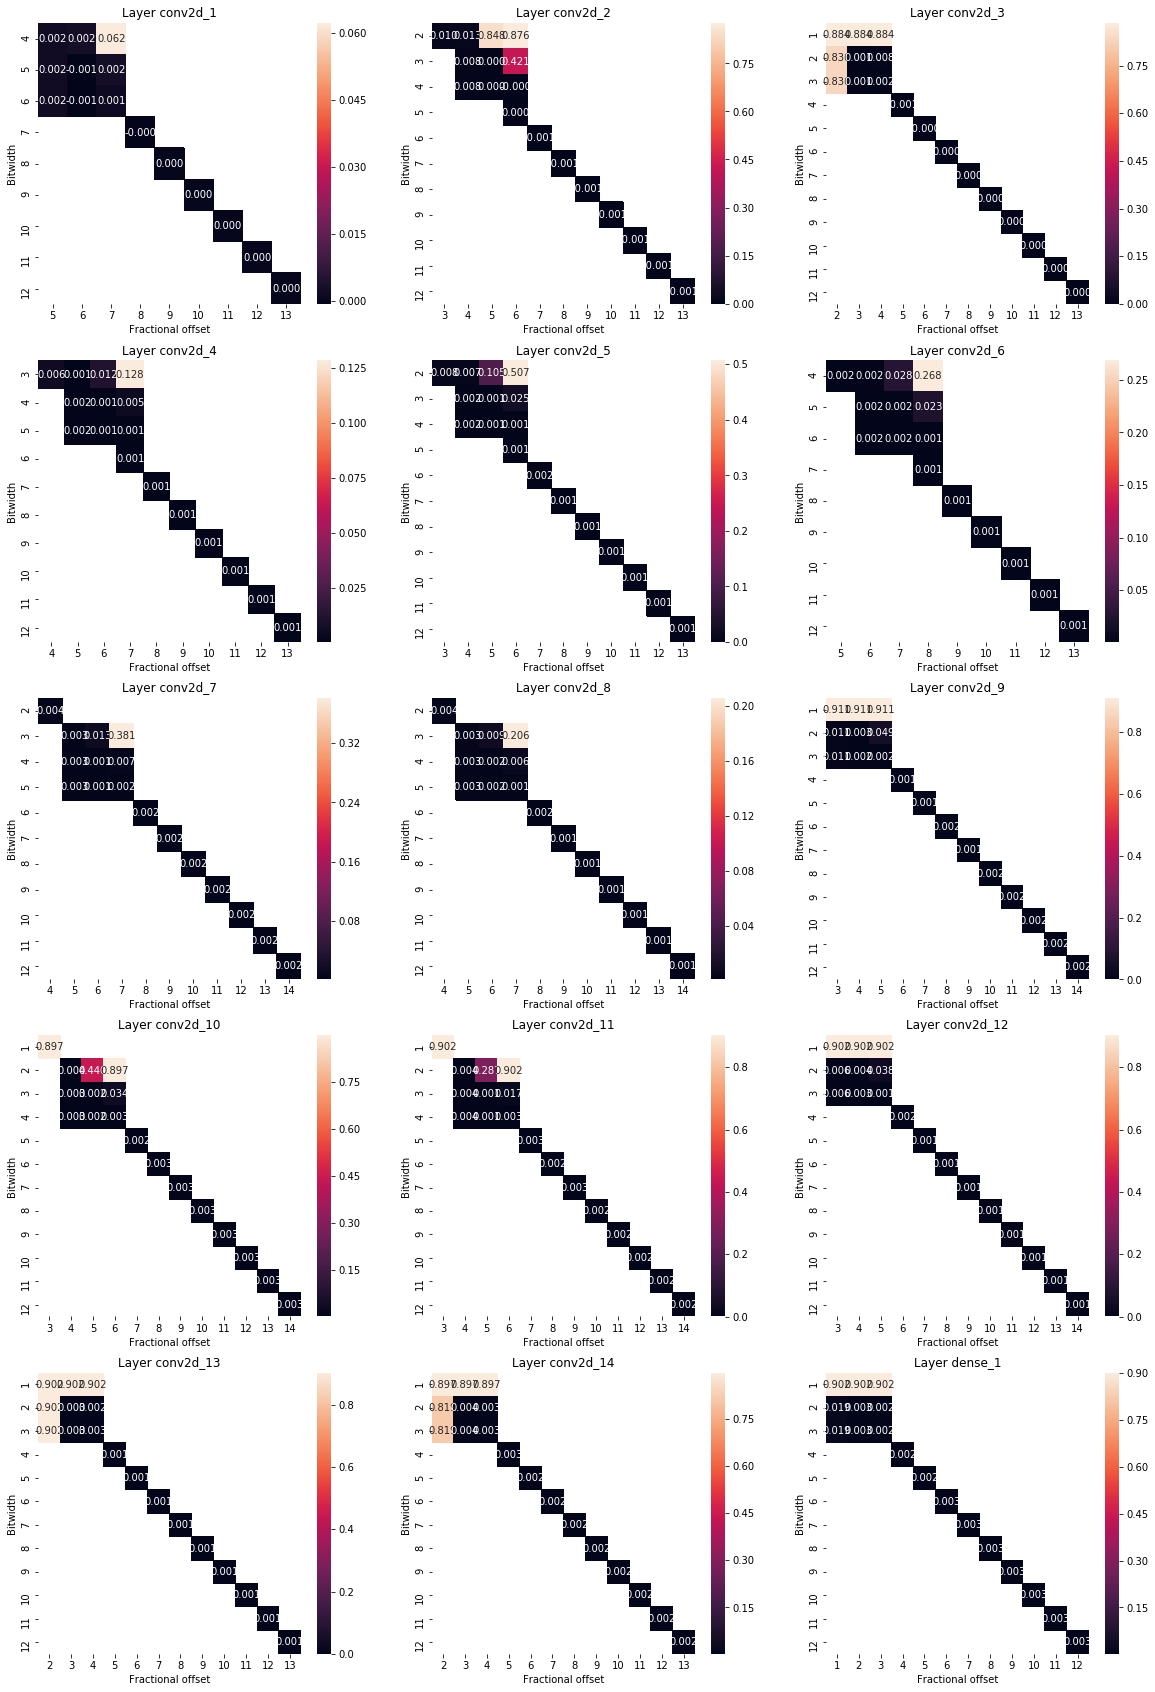

In [8]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(model_arch, name, t_d, float_model_acc)
w_scores, opt_params_weights, acc_drop_w = opts.run(acc_drop_config, 'weights', start_bw = 12)
opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [9]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (5, 6), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (3, 5), 'conv2d_5': (3, 5), 'conv2d_6': (5, 7), 'conv2d_7': (4, 6), 'conv2d_8': (4, 6), 'conv2d_9': (2, 4), 'conv2d_10': (3, 5), 'conv2d_11': (3, 5), 'conv2d_12': (3, 5), 'conv2d_13': (2, 4), 'conv2d_14': (2, 4), 'dense_1': (2, 3)}, biases={}, activations={})

#### Biases

In [10]:
acc_drop_config = {
    layer_names[i - 1]: total_acc_drop for i in range(1, len(layer_names) + 1)
}

{'conv2d_1': [8, 12], 'conv2d_2': [8, 12], 'conv2d_3': [8, 12], 'conv2d_4': [8, 11], 'conv2d_5': [8, 11], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 11], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Quantizing layer conv2d_1
Global opt: (2, 6) Local opt: (3, 7) Performance diff: 0.002018
Chosen:  (3, 7)
After quantizing biases of layer conv2d_1 | Measured accuracy drop 0.000807 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_2
Global opt: (1, 5) Local opt: (2, 6) Performance diff: 0.000404
Chosen:  (1, 5)
After quantizing biases of layer conv2d_2 | Measured accuracy drop 0.001211 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_3
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing biases of layer conv2d_3 | Measured accuracy drop 0.001211 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d

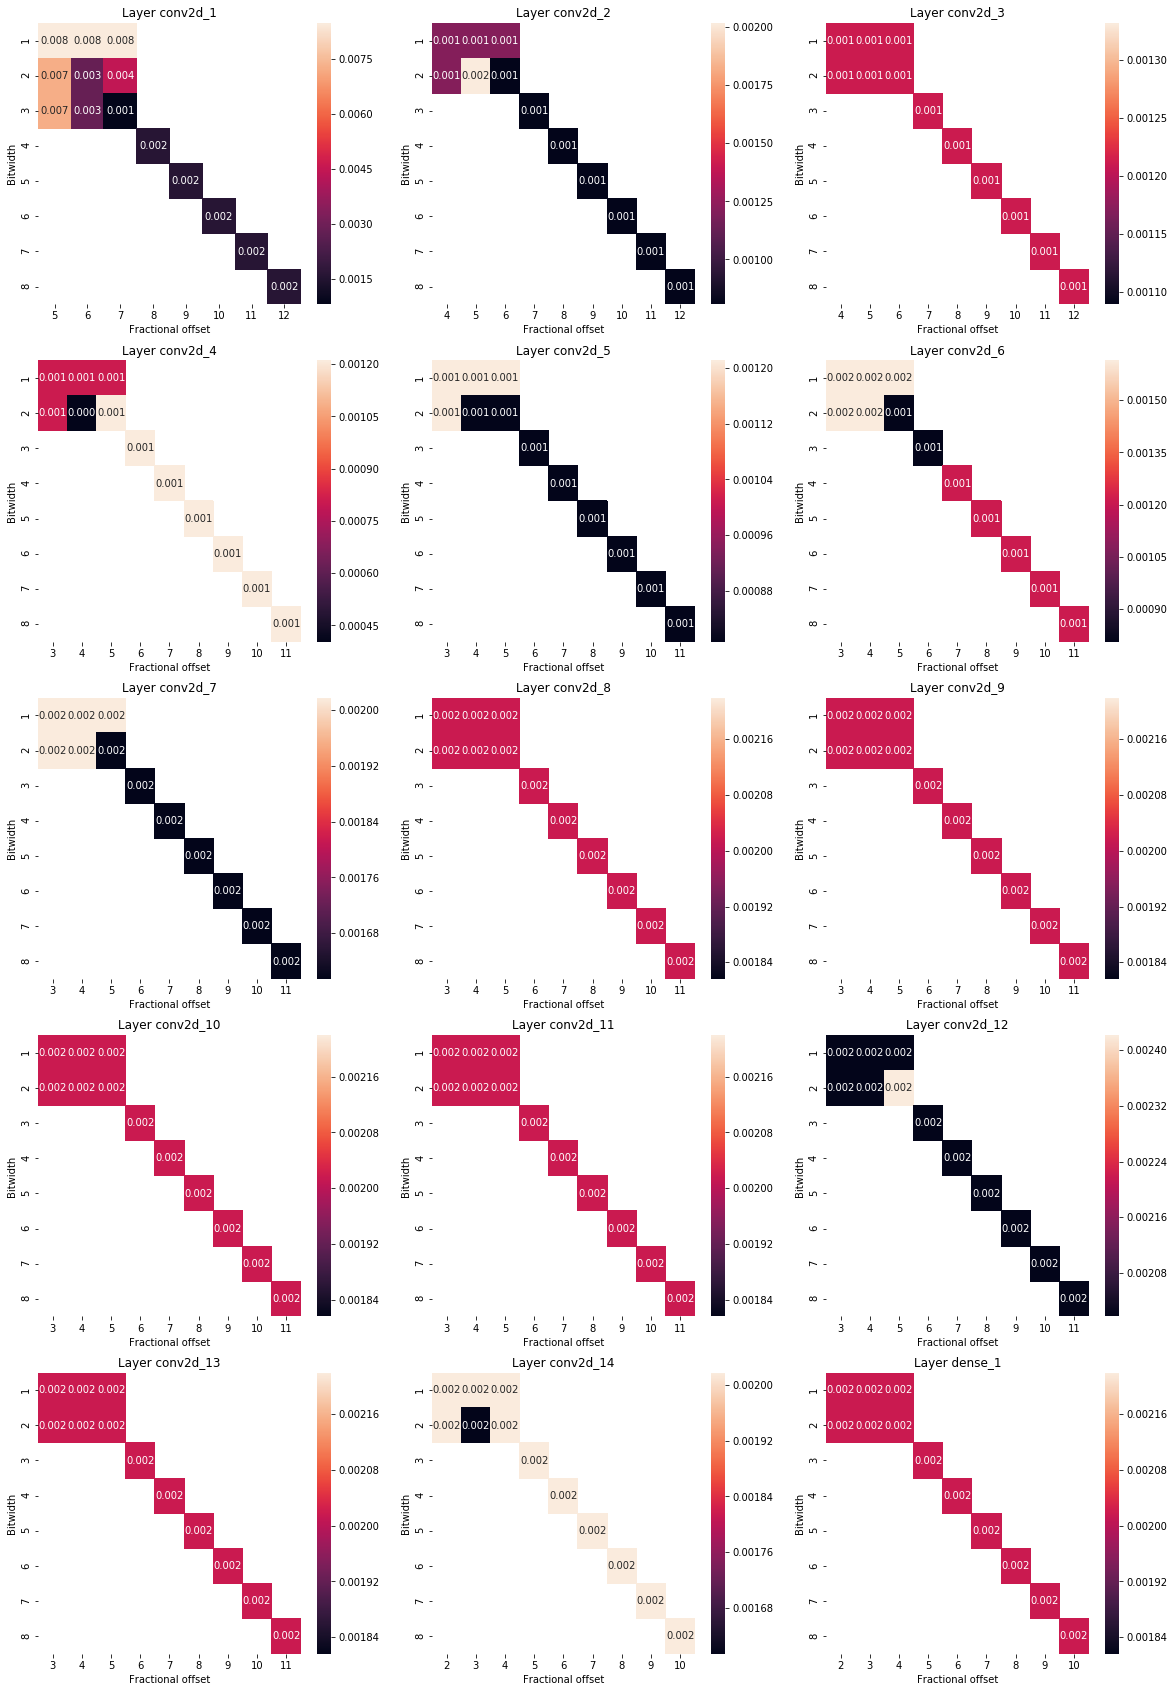

In [11]:
b_scores, opt_params_biases, acc_drop_b = opts.run(acc_drop_config, 'biases', start_bw = 8)
opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [12]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (5, 6), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (3, 5), 'conv2d_5': (3, 5), 'conv2d_6': (5, 7), 'conv2d_7': (4, 6), 'conv2d_8': (4, 6), 'conv2d_9': (2, 4), 'conv2d_10': (3, 5), 'conv2d_11': (3, 5), 'conv2d_12': (3, 5), 'conv2d_13': (2, 4), 'conv2d_14': (2, 4), 'dense_1': (2, 3)}, biases={'conv2d_1': (3, 7), 'conv2d_2': (1, 5), 'conv2d_3': (1, 4), 'conv2d_4': (1, 4), 'conv2d_5': (1, 4), 'conv2d_6': (1, 4), 'conv2d_7': (1, 4), 'conv2d_8': (1, 3), 'conv2d_9': (1, 3), 'conv2d_10': (1, 3), 'conv2d_11': (1, 3), 'conv2d_12': (1, 3), 'conv2d_13': (1, 3), 'conv2d_14': (1, 3), 'dense_1': (1, 2)}, activations={})

#### Activations

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 7], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 8], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 7], 'conv2d_13': [12, 7], 'conv2d_14': [12, 7], 'dense_1': [12, 6]}
Quantizing layer conv2d_1
Global opt: (4, 5) Local opt: (5, 6) Performance diff: 0.000404
Chosen:  (4, 5)
After quantizing activations of layer conv2d_1 | Measured accuracy drop 0.002421 | Acceptable accuracy drop: 0.005333
Quantizing layer conv2d_2
Global opt: (4, 2) Local opt: (5, 2) Performance diff: 0.001614
Chosen:  (5, 2)
After quantizing activations of layer conv2d_2 | Measured accuracy drop 0.003632 | Acceptable accuracy drop: 0.005667
Quantizing layer conv2d_3
Global opt: (4, 1) Local opt: (5, 1) Performance diff: 0.001211
Chosen:  (4, 1)
After quantizing activations of layer conv2d_3 | Measured accuracy drop 0.003632 | Acceptable accuracy drop: 0.006000
Quantiz

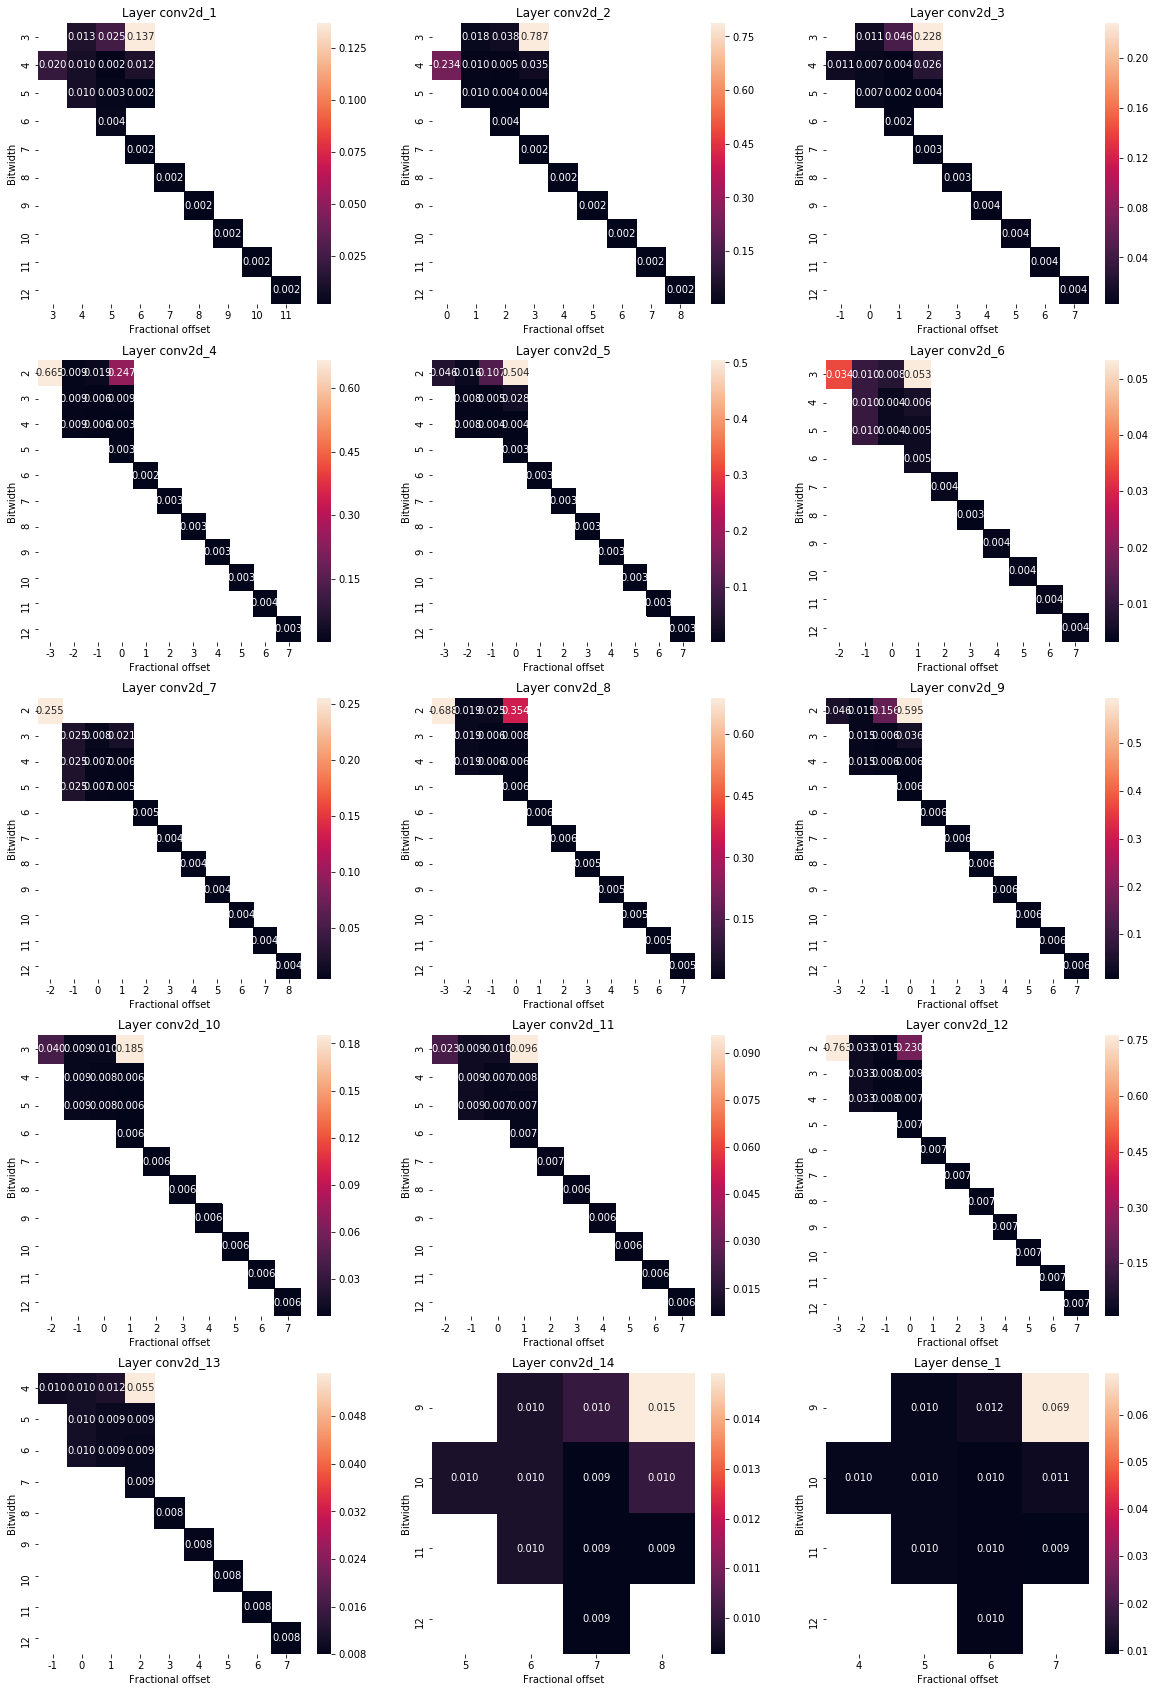

In [13]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names), total_acc_drop) for i in range(1, len(layer_names) + 1)
}

a_scores, opt_params_act, acc_drop_a = opts.run(acc_drop_config, 'activations', start_bw = 12)
opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [14]:
float_model_a1 = []
fxp_model_a1 = []

for i in range(4):
    float_model = model_data.Model(name, test_data[i], model=model_arch.get_float_model())
    float_model_a1.append(float_model.evaluate_accuracy()[1])
    
    fxp_model = fxp_quantize.fix_model_quantization(model_arch, name, test_data[i], opts.quant_evaluator.quant_params)
    fxp_model_a1.append(fxp_model.evaluate_accuracy()[1])

In [15]:
float_model_a1, fxp_model_a1

([0.9912, 0.994, 0.9972, 0.9976], [0.9816, 0.9832, 0.992, 0.99])

<BarContainer object of 4 artists>

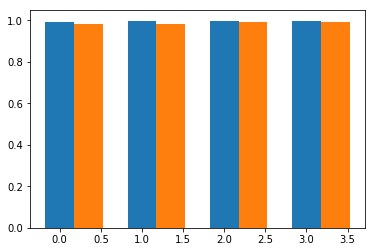

In [16]:
plt.figure()
plt.bar(np.arange(4), float_model_a1, width=0.35)
plt.bar(np.arange(4) + 0.35, fxp_model_a1, width=0.35)

In [17]:
with open(output_path + 'opt_params.p', 'rb') as f:
    opt_params = pickle.load(f)

In [18]:
bws_small = {}
bws_original = {}
qp = opts.quant_evaluator.quant_params._asdict()
for k in qp:
    bws_small[k] = [qp[k][layer][0] for layer in qp[k]]
    bws_original[k] = [opt_params[k][layer][0] for layer in opt_params[k]]

In [19]:
bws_small # (2500 samples)

{'weights': [5, 3, 2, 3, 3, 5, 4, 4, 2, 3, 3, 3, 2, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [4, 5, 4, 4, 4, 4, 5, 3, 3, 4, 4, 3, 5, 10, 10]}

In [20]:
bws_original # 10000 samples

{'weights': [5, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [6, 4, 4, 4, 3, 5, 5, 3, 4, 4, 3, 3, 3, 3, 5]}

In [21]:
memory_consumption = evaluation_metrics.evaluate_memory_consumption(fxp_model.model, layer_names, opts.quant_evaluator.quant_params._asdict())
for k in memory_consumption:
    print(f'Memory consumption of {k} (KB): {memory_consumption[k]}')

Memory consumption of weights (KB): 112.83203125
Memory consumption of biases (KB): 0.094970703125
Memory consumption of activations (KB): 67.98095703125


## Fold 2

In [22]:
t_d = test_data[1]
model_obj = model_data.Model(name, t_d, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

0.994


{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 14], 'conv2d_8': [12, 14], 'conv2d_9': [12, 14], 'conv2d_10': [12, 14], 'conv2d_11': [12, 14], 'conv2d_12': [12, 14], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Quantizing layer conv2d_1
Global opt: (5, 6) Local opt: (5, 6) Performance diff: 0.000000
Chosen:  (5, 6)
After quantizing weights of layer conv2d_1 | Measured accuracy drop -0.000402 | Acceptable accuracy drop: 0.000333
Quantizing layer conv2d_2
Global opt: (3, 5) Local opt: (3, 5) Performance diff: 0.000000
Chosen:  (3, 5)
After quantizing weights of layer conv2d_2 | Measured accuracy drop -0.001207 | Acceptable accuracy drop: 0.000667
Quantizing layer conv2d_3
Global opt: (2, 3) Local opt: (2, 3) Performance diff: 0.000000
Chosen:  (2, 3)
After quantizing weights of layer conv2d_3 | Measured accuracy drop 0.000402 | Acceptable accuracy drop: 0.001000
Qua

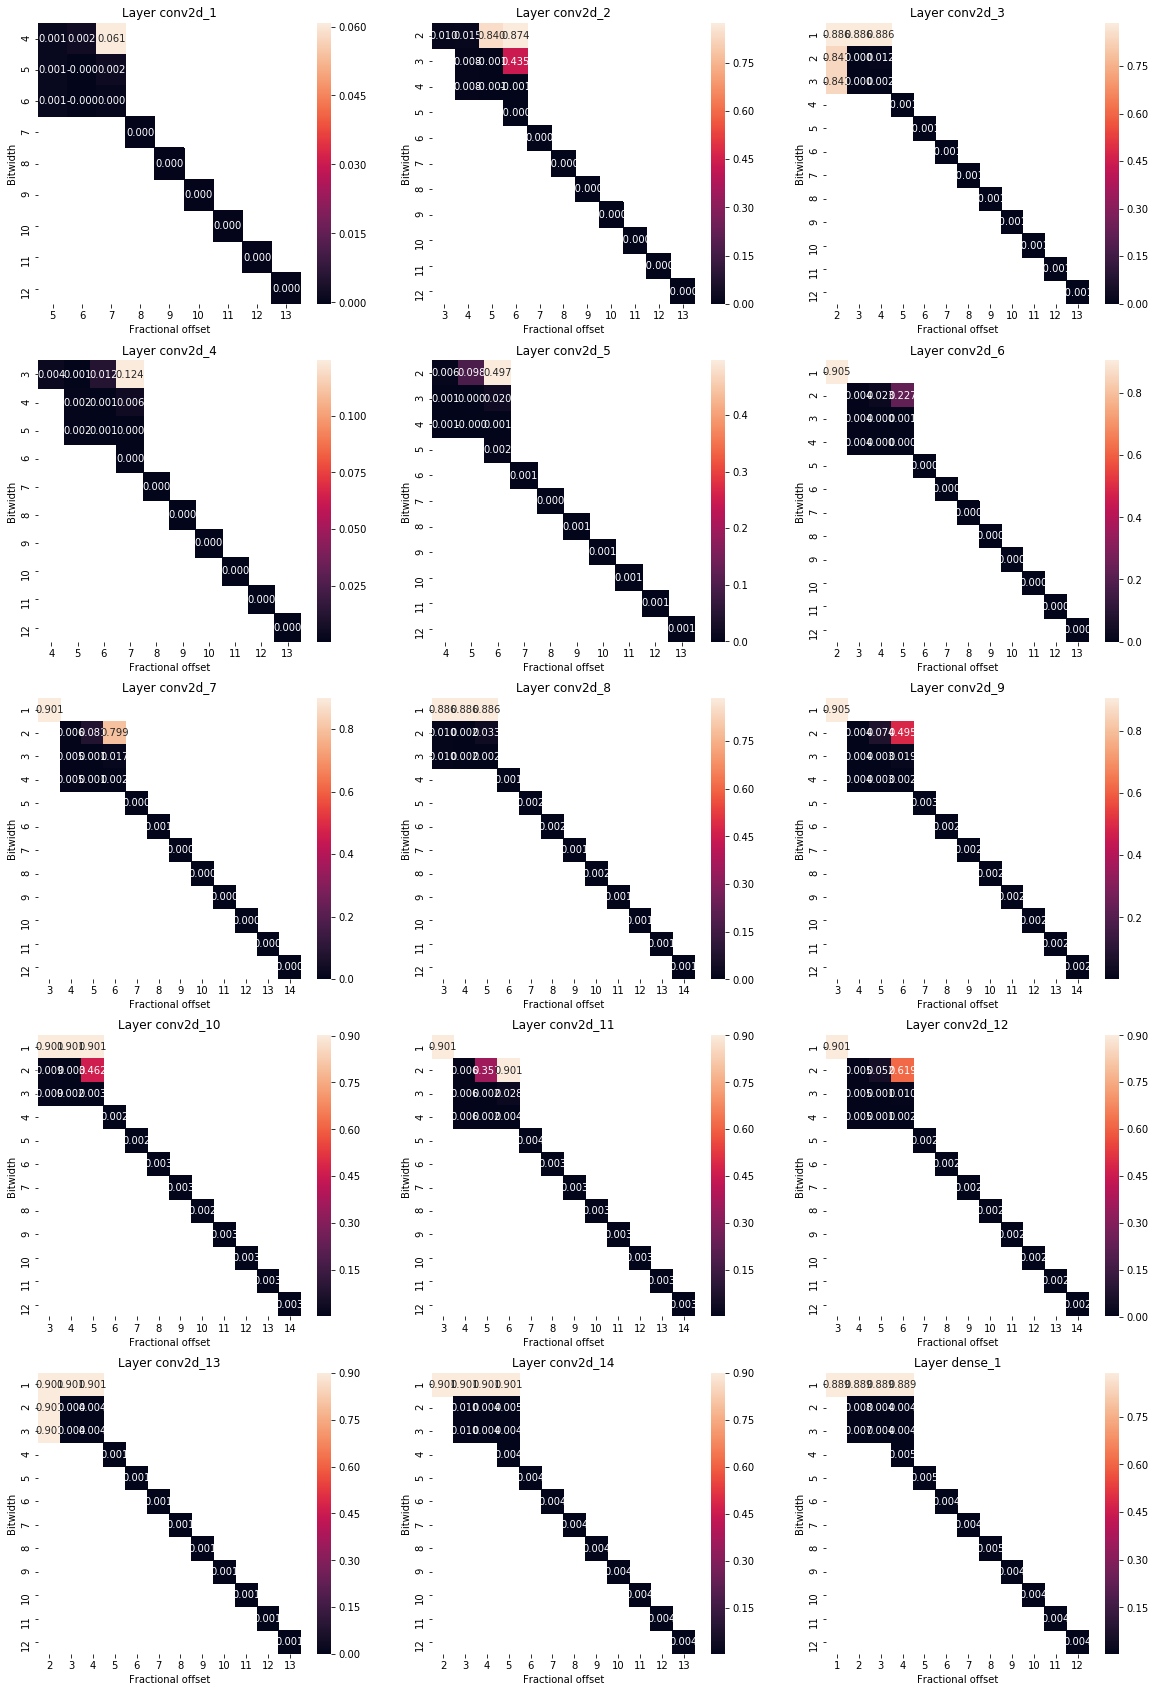

In [23]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(model_arch, name, t_d, float_model_acc)
w_scores, opt_params_weights, acc_drop_w = opts.run(acc_drop_config, 'weights', start_bw = 12)
opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [24]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (5, 6), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (4, 6), 'conv2d_5': (3, 5), 'conv2d_6': (3, 4), 'conv2d_7': (3, 5), 'conv2d_8': (2, 4), 'conv2d_9': (3, 5), 'conv2d_10': (2, 4), 'conv2d_11': (3, 5), 'conv2d_12': (3, 5), 'conv2d_13': (2, 3), 'conv2d_14': (2, 4), 'dense_1': (2, 3)}, biases={}, activations={})

#### Biases

In [25]:
acc_drop_config = {
    layer_names[i - 1]: total_acc_drop for i in range(1, len(layer_names) + 1)
}

{'conv2d_1': [8, 12], 'conv2d_2': [8, 12], 'conv2d_3': [8, 12], 'conv2d_4': [8, 11], 'conv2d_5': [8, 11], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 11], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Quantizing layer conv2d_1
Global opt: (2, 6) Local opt: (3, 7) Performance diff: 0.002012
Chosen:  (3, 7)
After quantizing biases of layer conv2d_1 | Measured accuracy drop 0.002817 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_2
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing biases of layer conv2d_2 | Measured accuracy drop 0.002817 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_3
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing biases of layer conv2d_3 | Measured accuracy drop 0.002817 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d

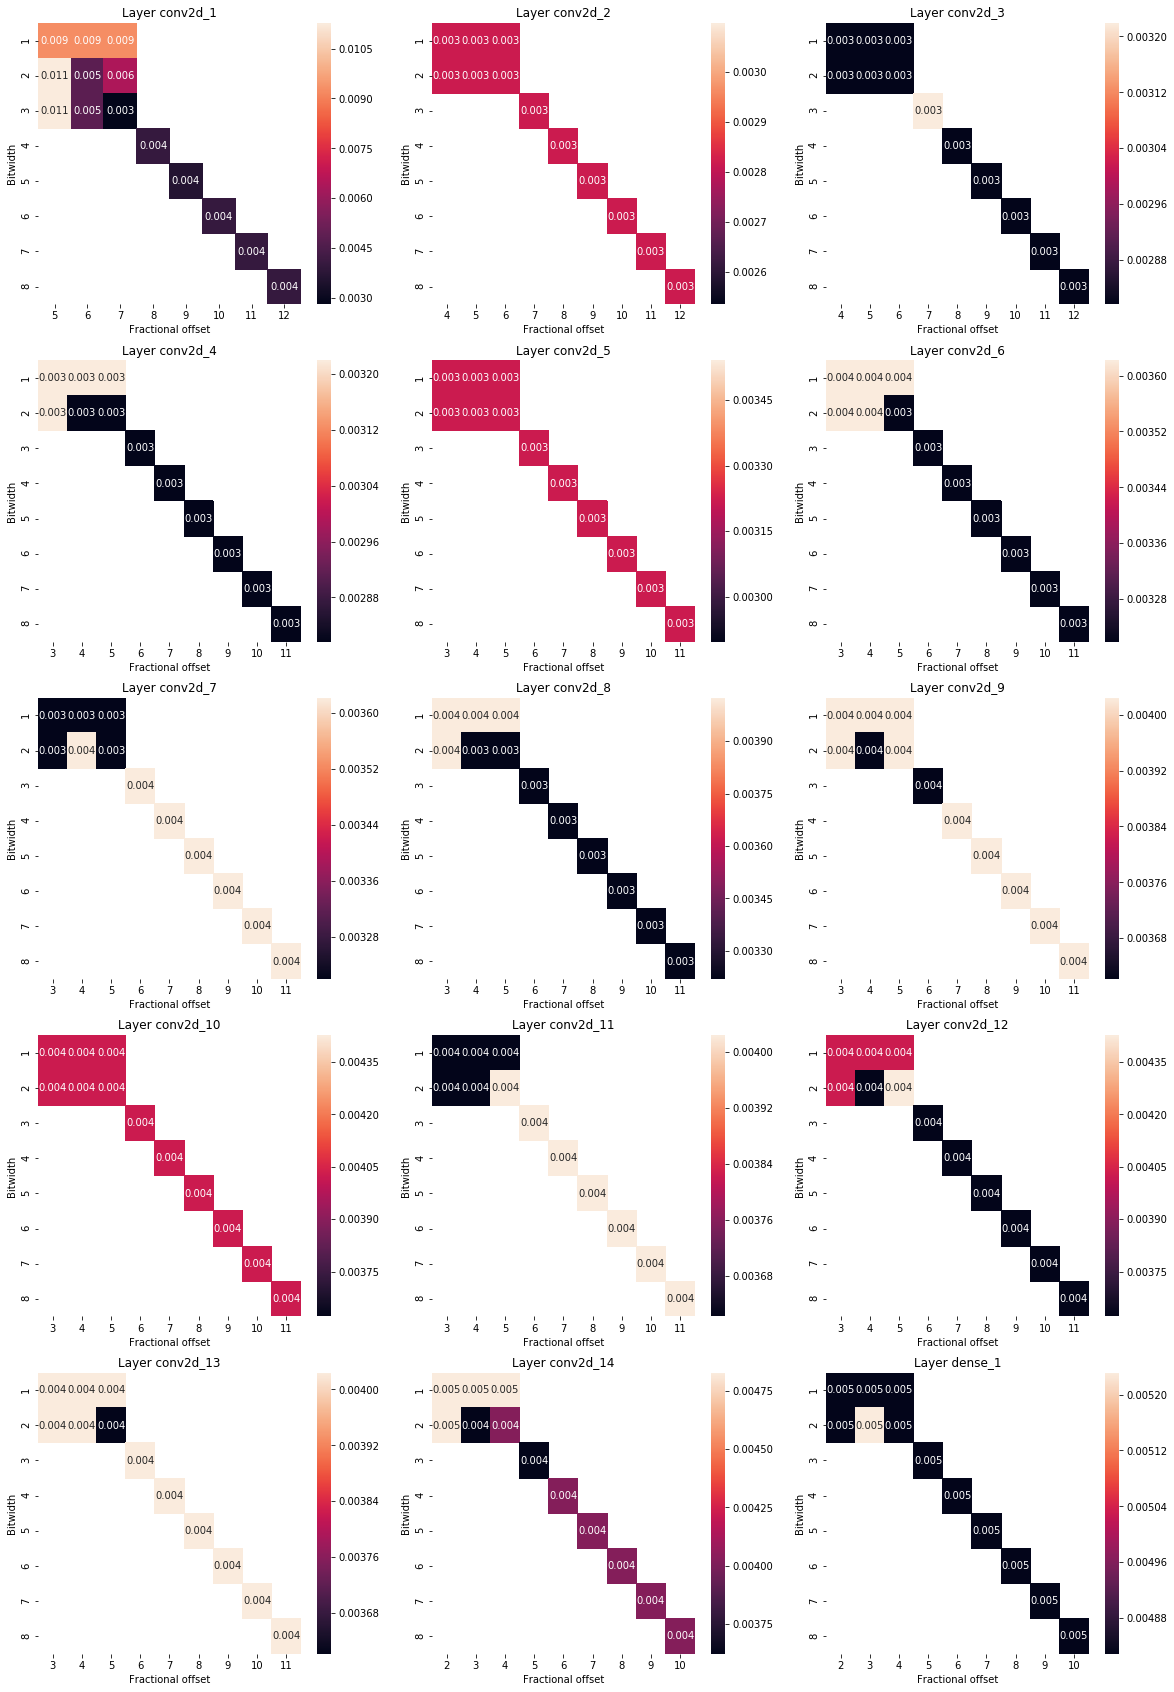

In [26]:
b_scores, opt_params_biases, acc_drop_b = opts.run(acc_drop_config, 'biases', start_bw = 8)
opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [27]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (5, 6), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (4, 6), 'conv2d_5': (3, 5), 'conv2d_6': (3, 4), 'conv2d_7': (3, 5), 'conv2d_8': (2, 4), 'conv2d_9': (3, 5), 'conv2d_10': (2, 4), 'conv2d_11': (3, 5), 'conv2d_12': (3, 5), 'conv2d_13': (2, 3), 'conv2d_14': (2, 4), 'dense_1': (2, 3)}, biases={'conv2d_1': (3, 7), 'conv2d_2': (1, 4), 'conv2d_3': (1, 4), 'conv2d_4': (1, 4), 'conv2d_5': (1, 3), 'conv2d_6': (1, 4), 'conv2d_7': (1, 3), 'conv2d_8': (1, 4), 'conv2d_9': (1, 4), 'conv2d_10': (1, 3), 'conv2d_11': (1, 3), 'conv2d_12': (1, 4), 'conv2d_13': (1, 4), 'conv2d_14': (1, 3), 'dense_1': (1, 2)}, activations={})

#### Activations

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 7], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 7], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 7], 'conv2d_13': [12, 7], 'conv2d_14': [12, 7], 'dense_1': [12, 6]}
Quantizing layer conv2d_1
Global opt: (5, 5) Local opt: (6, 6) Performance diff: 0.002414
Chosen:  (6, 6)
After quantizing activations of layer conv2d_1 | Measured accuracy drop 0.002012 | Acceptable accuracy drop: 0.005333
Quantizing layer conv2d_2
Global opt: (5, 2) Local opt: (6, 3) Performance diff: 0.000805
Chosen:  (5, 2)
After quantizing activations of layer conv2d_2 | Measured accuracy drop 0.004829 | Acceptable accuracy drop: 0.005667
Quantizing layer conv2d_3
Global opt: (4, 0) Local opt: (5, 1) Performance diff: 0.000805
Chosen:  (4, 0)
After quantizing activations of layer conv2d_3 | Measured accuracy drop 0.005231 | Acceptable accuracy drop: 0.006000
Quantiz

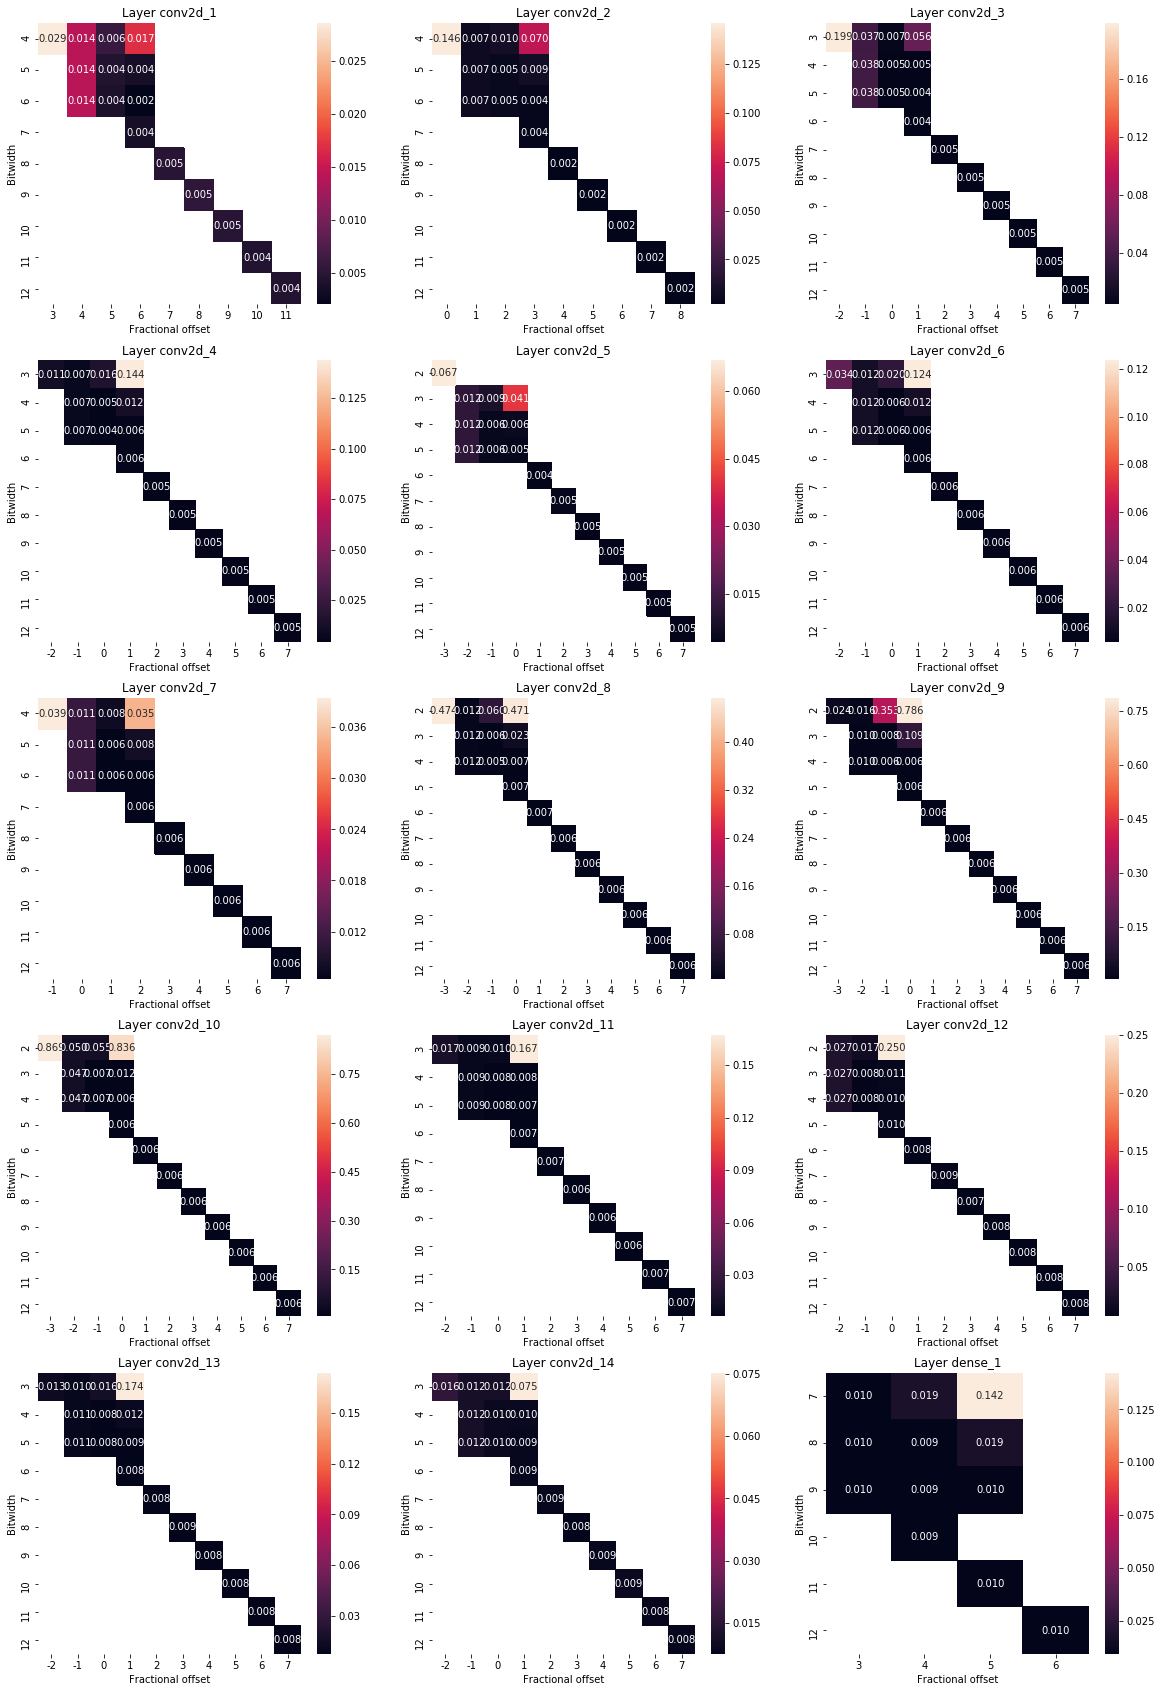

In [28]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names), total_acc_drop) for i in range(1, len(layer_names) + 1)
}

a_scores, opt_params_act, acc_drop_a = opts.run(acc_drop_config, 'activations', start_bw = 12)
opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [29]:
float_model_a2 = []
fxp_model_a2 = []

for i in range(4):
    float_model = model_data.Model(name, test_data[i], model=model_arch.get_float_model())
    float_model_a2.append(float_model.evaluate_accuracy()[1])
    
    fxp_model = fxp_quantize.fix_model_quantization(model_arch, name, test_data[i], opts.quant_evaluator.quant_params)
    fxp_model_a2.append(fxp_model.evaluate_accuracy()[1])

In [30]:
float_model_a2, fxp_model_a2

([0.9912, 0.994, 0.9972, 0.9976], [0.9768, 0.9848, 0.9896, 0.9912])

<BarContainer object of 4 artists>

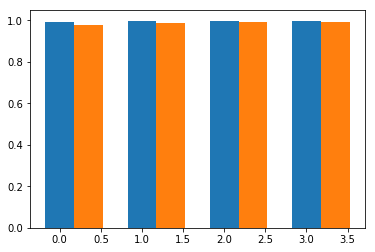

In [31]:
plt.figure()
plt.bar(np.arange(4), float_model_a2, width=0.35)
plt.bar(np.arange(4) + 0.35, fxp_model_a2, width=0.35)

In [32]:
with open(output_path + 'opt_params.p', 'rb') as f:
    opt_params = pickle.load(f)

In [33]:
bws_small = {}
bws_original = {}
qp = opts.quant_evaluator.quant_params._asdict()
for k in qp:
    bws_small[k] = [qp[k][layer][0] for layer in qp[k]]
    bws_original[k] = [opt_params[k][layer][0] for layer in opt_params[k]]

In [34]:
bws_small # (2500 samples)

{'weights': [5, 3, 2, 4, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [6, 5, 4, 4, 4, 4, 5, 3, 4, 3, 4, 3, 4, 4, 8]}

In [35]:
bws_original # 10000 samples

{'weights': [5, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [6, 4, 4, 4, 3, 5, 5, 3, 4, 4, 3, 3, 3, 3, 5]}

In [36]:
memory_consumption = evaluation_metrics.evaluate_memory_consumption(fxp_model.model, layer_names, opts.quant_evaluator.quant_params._asdict())
for k in memory_consumption:
    print(f'Memory consumption of {k} (KB): {memory_consumption[k]}')

Memory consumption of weights (KB): 100.45703125
Memory consumption of biases (KB): 0.094970703125
Memory consumption of activations (KB): 72.384765625


## Fold 3

In [37]:
t_d = test_data[2]
model_obj = model_data.Model(name, t_d, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

0.9972


{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 14], 'conv2d_8': [12, 14], 'conv2d_9': [12, 14], 'conv2d_10': [12, 14], 'conv2d_11': [12, 14], 'conv2d_12': [12, 14], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Quantizing layer conv2d_1
Global opt: (7, 9) Local opt: (7, 9) Performance diff: 0.000000
Chosen:  (7, 9)
After quantizing weights of layer conv2d_1 | Measured accuracy drop 0.000000 | Acceptable accuracy drop: 0.000333
Quantizing layer conv2d_2
Global opt: (3, 5) Local opt: (3, 5) Performance diff: 0.000000
Chosen:  (3, 5)
After quantizing weights of layer conv2d_2 | Measured accuracy drop 0.000000 | Acceptable accuracy drop: 0.000667
Quantizing layer conv2d_3
Global opt: (2, 3) Local opt: (2, 3) Performance diff: 0.000000
Chosen:  (2, 3)
After quantizing weights of layer conv2d_3 | Measured accuracy drop 0.000802 | Acceptable accuracy drop: 0.001000
Quant

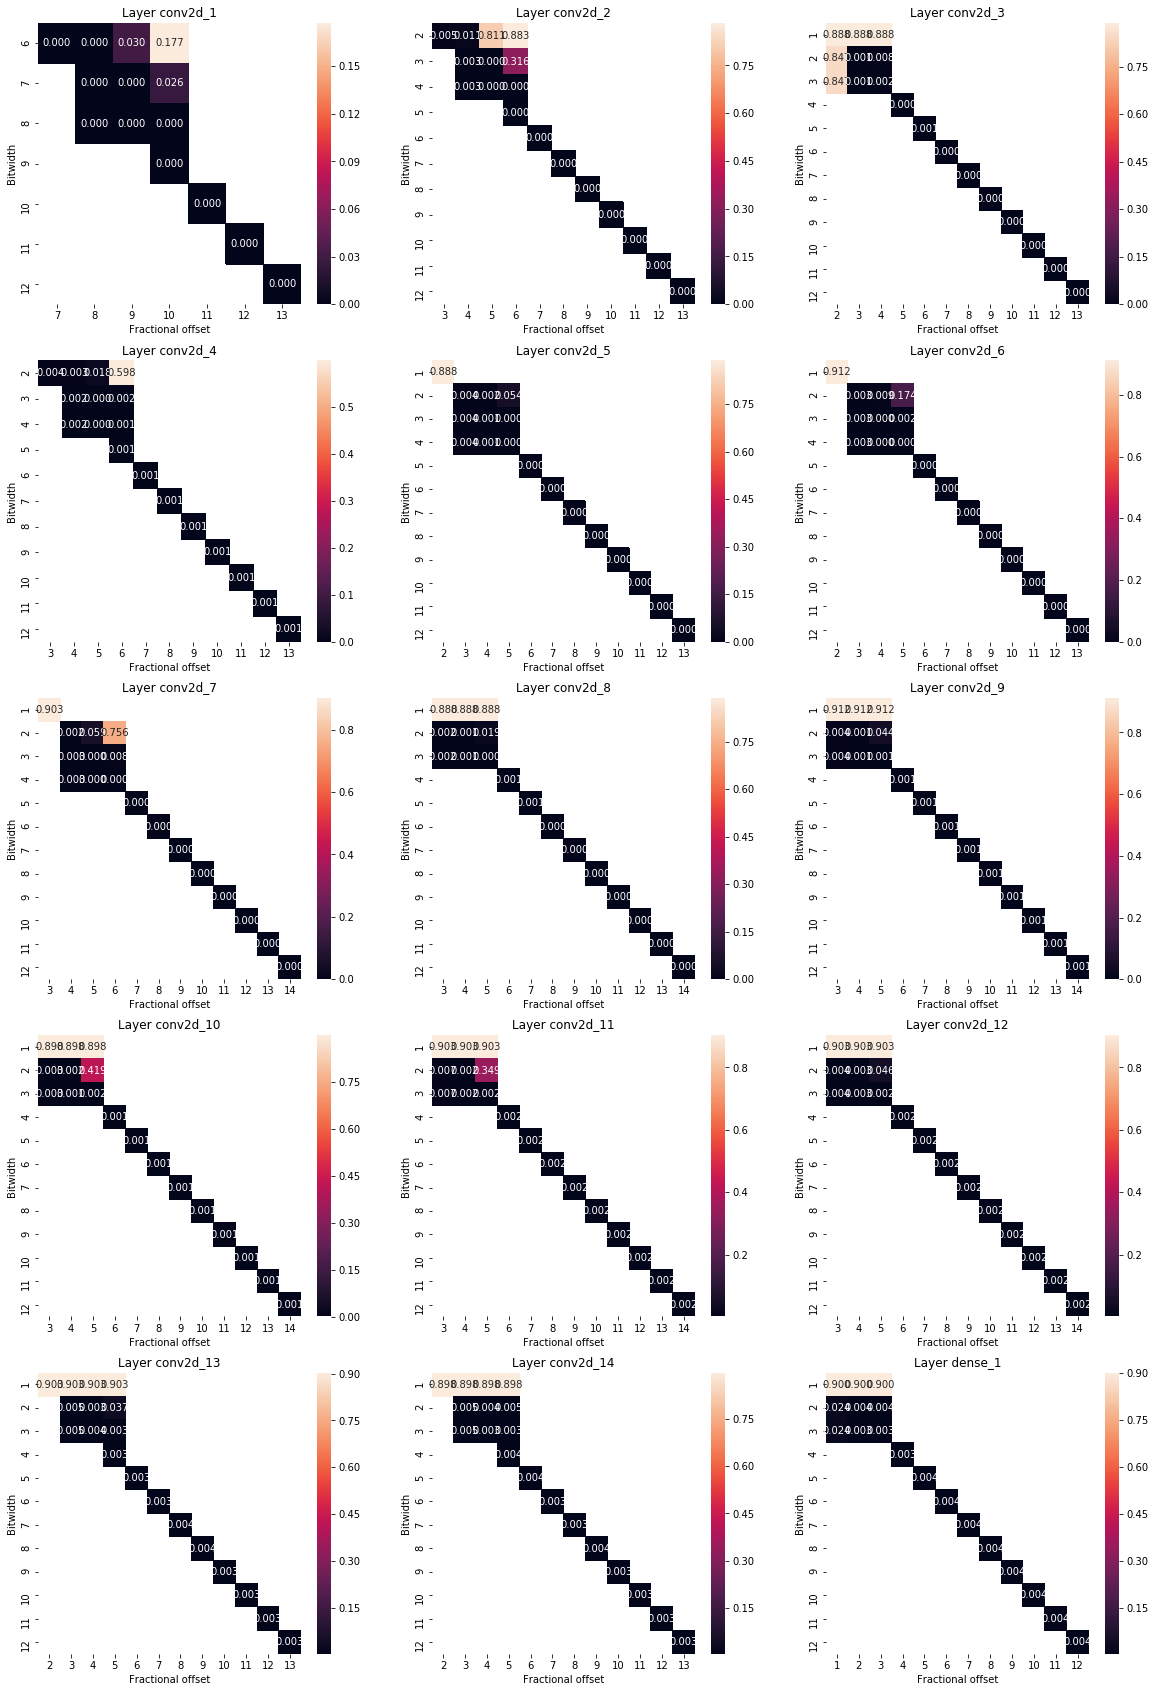

In [38]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(model_arch, name, t_d, float_model_acc)
w_scores, opt_params_weights, acc_drop_w = opts.run(acc_drop_config, 'weights', start_bw = 12)
opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [39]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (7, 9), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (3, 5), 'conv2d_5': (3, 5), 'conv2d_6': (3, 4), 'conv2d_7': (3, 5), 'conv2d_8': (2, 4), 'conv2d_9': (2, 4), 'conv2d_10': (2, 4), 'conv2d_11': (2, 4), 'conv2d_12': (2, 4), 'conv2d_13': (2, 4), 'conv2d_14': (2, 4), 'dense_1': (2, 2)}, biases={}, activations={})

#### Biases

In [40]:
acc_drop_config = {
    layer_names[i - 1]: total_acc_drop for i in range(1, len(layer_names) + 1)
}

{'conv2d_1': [8, 12], 'conv2d_2': [8, 12], 'conv2d_3': [8, 12], 'conv2d_4': [8, 11], 'conv2d_5': [8, 11], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 11], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Quantizing layer conv2d_1
Global opt: (3, 7) Local opt: (4, 8) Performance diff: 0.000802
Chosen:  (3, 7)
After quantizing biases of layer conv2d_1 | Measured accuracy drop 0.003610 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_2
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing biases of layer conv2d_2 | Measured accuracy drop 0.003610 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_3
Global opt: (1, 5) Local opt: (1, 4) Performance diff: 0.000000
Chosen:  (1, 4)
After quantizing biases of layer conv2d_3 | Measured accuracy drop 0.003610 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d

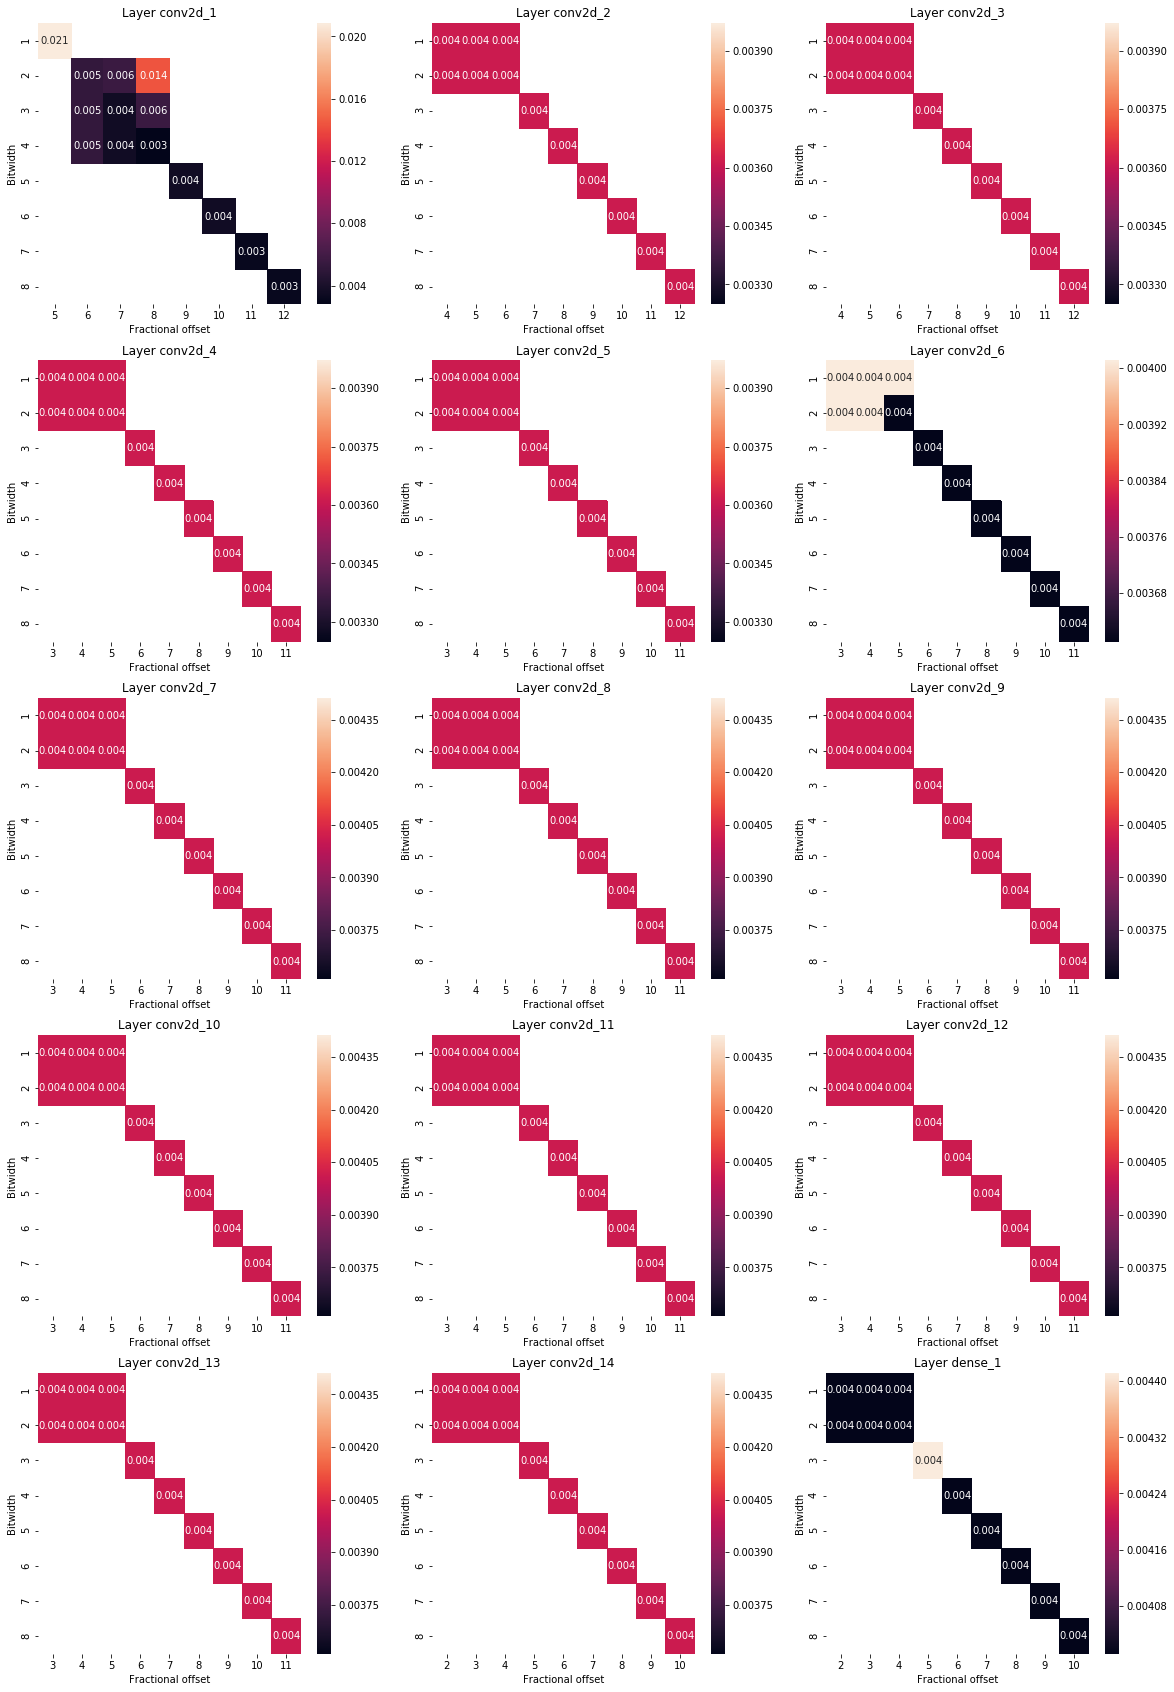

In [41]:
b_scores, opt_params_biases, acc_drop_b = opts.run(acc_drop_config, 'biases', start_bw = 8)
opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [42]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (7, 9), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (3, 5), 'conv2d_5': (3, 5), 'conv2d_6': (3, 4), 'conv2d_7': (3, 5), 'conv2d_8': (2, 4), 'conv2d_9': (2, 4), 'conv2d_10': (2, 4), 'conv2d_11': (2, 4), 'conv2d_12': (2, 4), 'conv2d_13': (2, 4), 'conv2d_14': (2, 4), 'dense_1': (2, 2)}, biases={'conv2d_1': (3, 7), 'conv2d_2': (1, 4), 'conv2d_3': (1, 4), 'conv2d_4': (1, 3), 'conv2d_5': (1, 3), 'conv2d_6': (1, 4), 'conv2d_7': (1, 3), 'conv2d_8': (1, 3), 'conv2d_9': (1, 3), 'conv2d_10': (1, 3), 'conv2d_11': (1, 3), 'conv2d_12': (1, 3), 'conv2d_13': (1, 3), 'conv2d_14': (1, 2), 'dense_1': (1, 2)}, activations={})

#### Activations

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 7], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 8], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 7], 'conv2d_13': [12, 7], 'conv2d_14': [12, 7], 'dense_1': [12, 6]}
Quantizing layer conv2d_1
Global opt: (5, 6) Local opt: (5, 6) Performance diff: 0.000000
Chosen:  (5, 6)
After quantizing activations of layer conv2d_1 | Measured accuracy drop 0.004011 | Acceptable accuracy drop: 0.005333
Quantizing layer conv2d_2
Global opt: (5, 2) Local opt: (5, 2) Performance diff: 0.000000
Chosen:  (5, 2)
After quantizing activations of layer conv2d_2 | Measured accuracy drop 0.002407 | Acceptable accuracy drop: 0.005667
Quantizing layer conv2d_3
Global opt: (3, 0) Local opt: (4, 1) Performance diff: 0.001604
Chosen:  (4, 1)
After quantizing activations of layer conv2d_3 | Measured accuracy drop 0.002407 | Acceptable accuracy drop: 0.006000
Quantiz

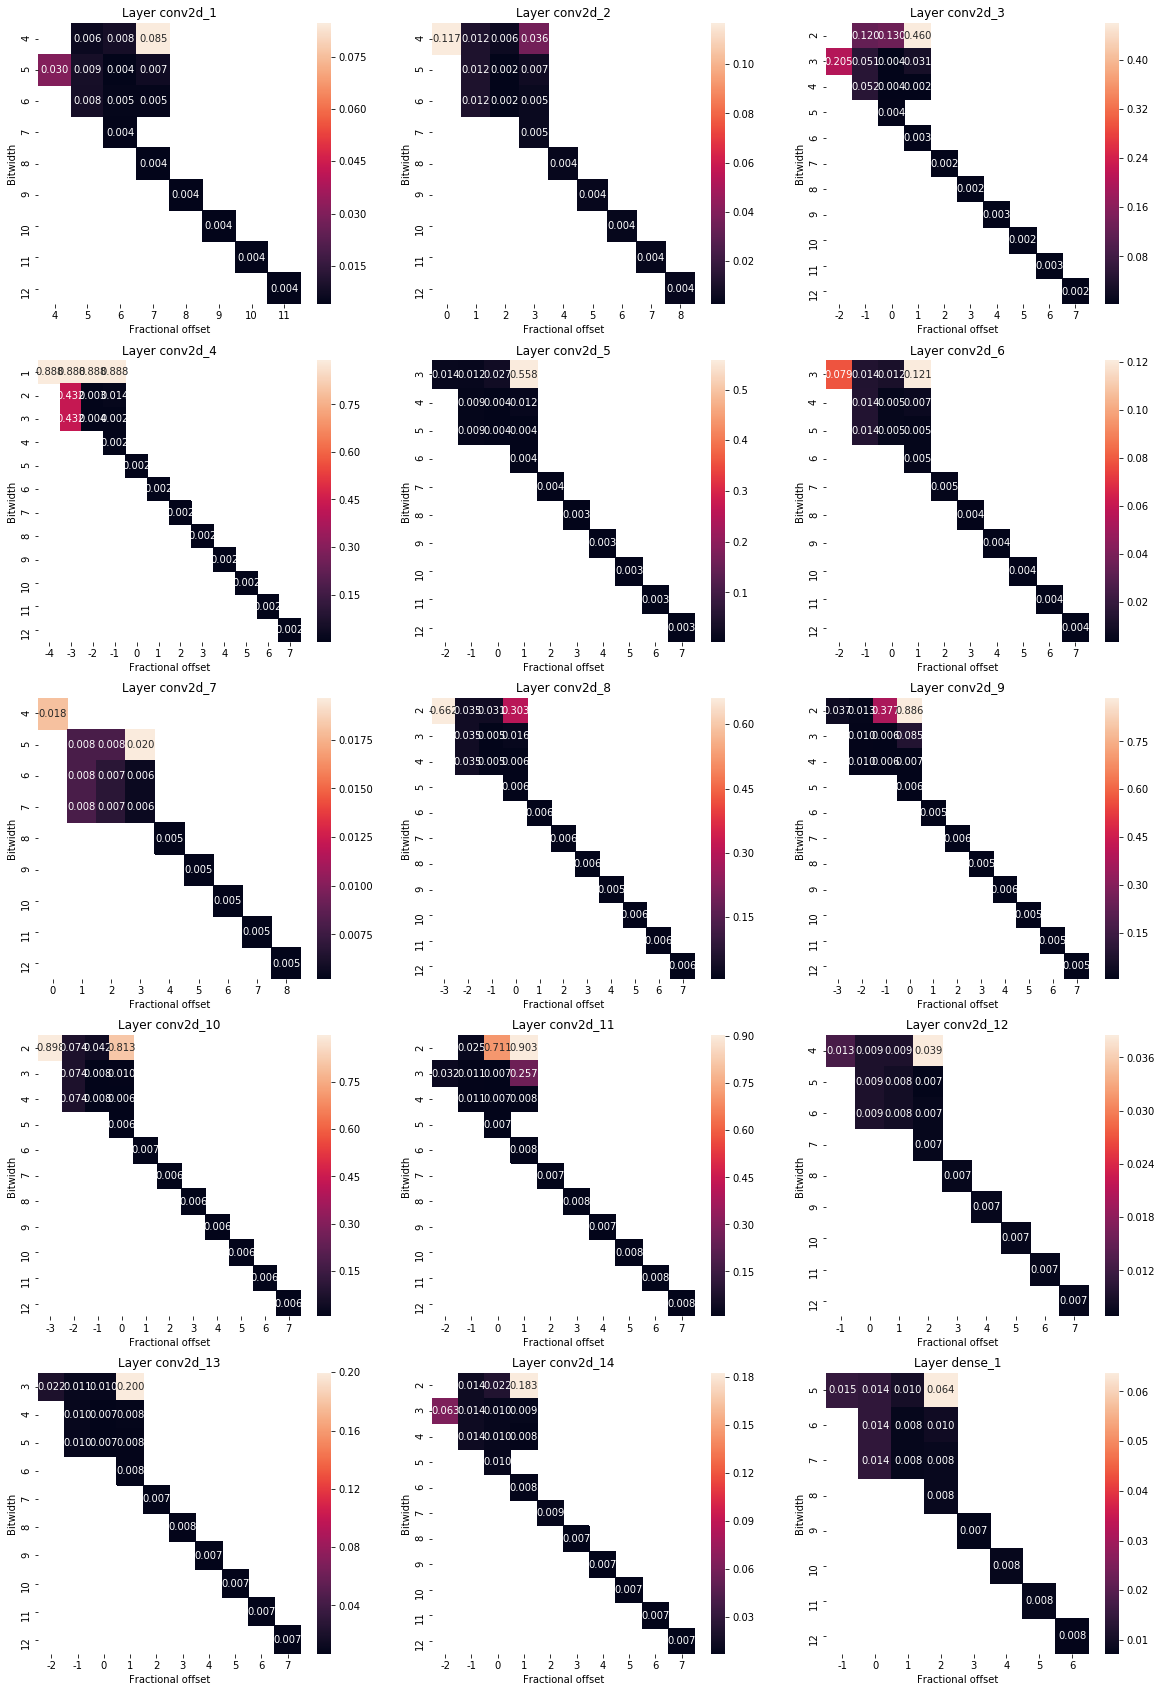

In [43]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names), total_acc_drop) for i in range(1, len(layer_names) + 1)
}

a_scores, opt_params_act, acc_drop_a = opts.run(acc_drop_config, 'activations', start_bw = 12)
opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [44]:
float_model_a3 = []
fxp_model_a3 = []

for i in range(4):
    float_model = model_data.Model(name, test_data[i], model=model_arch.get_float_model())
    float_model_a3.append(float_model.evaluate_accuracy()[1])

    fxp_model = fxp_quantize.fix_model_quantization(model_arch, name, test_data[i], opts.quant_evaluator.quant_params)
    fxp_model_a3.append(fxp_model.evaluate_accuracy()[1])

In [45]:
float_model_a3, fxp_model_a3

([0.9912, 0.994, 0.9972, 0.9976], [0.9604, 0.9716, 0.9892, 0.988])

<BarContainer object of 4 artists>

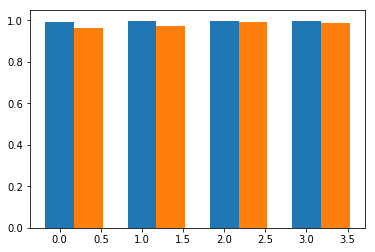

In [46]:
plt.figure()
plt.bar(np.arange(4), float_model_a3, width=0.35)
plt.bar(np.arange(4) + 0.35, fxp_model_a3, width=0.35)

In [47]:
with open(output_path + 'opt_params.p', 'rb') as f:
    opt_params = pickle.load(f)

In [48]:
bws_small = {}
bws_original = {}
qp = opts.quant_evaluator.quant_params._asdict()
for k in qp:
    bws_small[k] = [qp[k][layer][0] for layer in qp[k]]
    bws_original[k] = [opt_params[k][layer][0] for layer in opt_params[k]]

In [49]:
bws_small # (2500 samples)

{'weights': [7, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [5, 5, 4, 2, 4, 4, 6, 3, 3, 3, 3, 5, 4, 4, 6]}

In [50]:
bws_original # 10000 samples

{'weights': [5, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [6, 4, 4, 4, 3, 5, 5, 3, 4, 4, 3, 3, 3, 3, 5]}

In [51]:
memory_consumption = evaluation_metrics.evaluate_memory_consumption(fxp_model.model, layer_names, opts.quant_evaluator.quant_params._asdict())
for k in memory_consumption:
    print(f'Memory consumption of {k} (KB): {memory_consumption[k]}')

Memory consumption of weights (KB): 85.90234375
Memory consumption of biases (KB): 0.094970703125
Memory consumption of activations (KB): 65.78076171875


## Fold 4

In [52]:
t_d = test_data[3]
model_obj = model_data.Model(name, t_d, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

0.9976


{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 14], 'conv2d_8': [12, 14], 'conv2d_9': [12, 14], 'conv2d_10': [12, 14], 'conv2d_11': [12, 14], 'conv2d_12': [12, 14], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Quantizing layer conv2d_1
Global opt: (4, 5) Local opt: (4, 5) Performance diff: 0.000000
Chosen:  (4, 5)
After quantizing weights of layer conv2d_1 | Measured accuracy drop -0.000401 | Acceptable accuracy drop: 0.000333
Quantizing layer conv2d_2
Global opt: (3, 5) Local opt: (3, 5) Performance diff: 0.000000
Chosen:  (3, 5)
After quantizing weights of layer conv2d_2 | Measured accuracy drop -0.000401 | Acceptable accuracy drop: 0.000667
Quantizing layer conv2d_3
Global opt: (2, 3) Local opt: (2, 3) Performance diff: 0.000000
Chosen:  (2, 3)
After quantizing weights of layer conv2d_3 | Measured accuracy drop 0.000000 | Acceptable accuracy drop: 0.001000
Qua

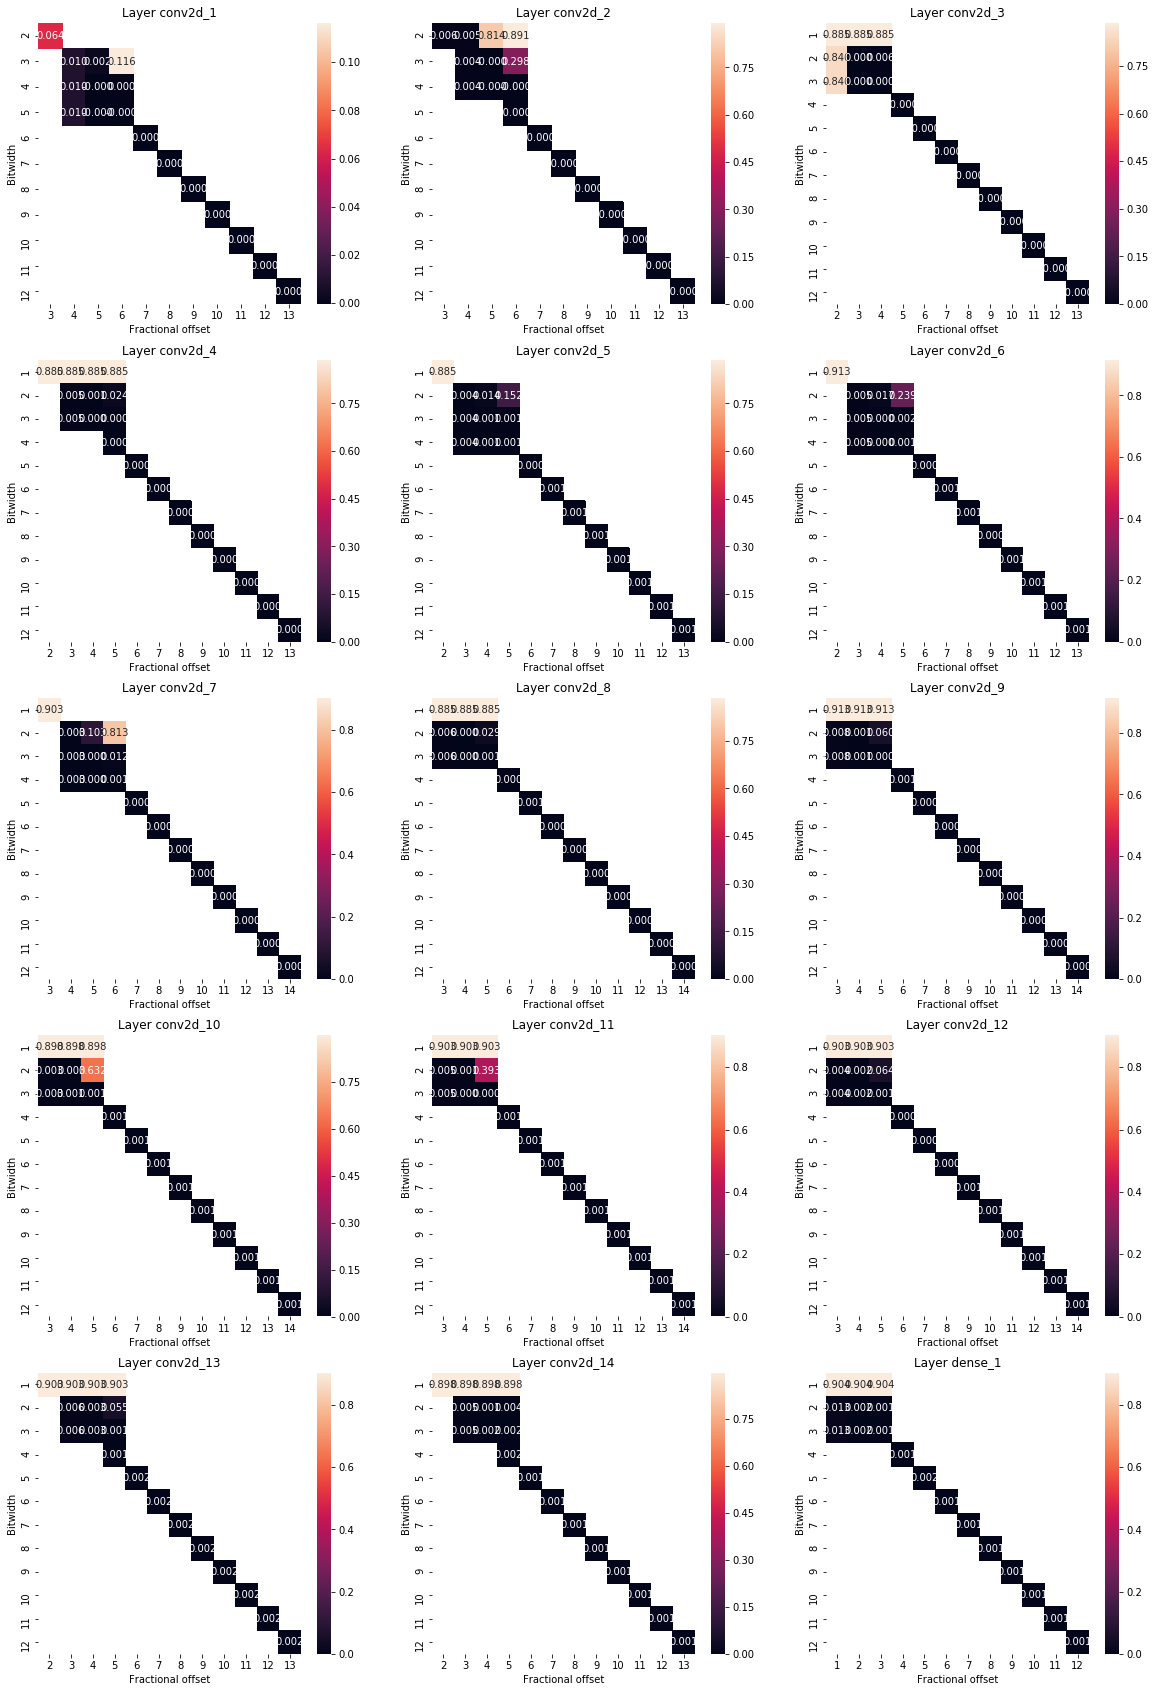

In [53]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(model_arch, name, t_d, float_model_acc)
w_scores, opt_params_weights, acc_drop_w = opts.run(acc_drop_config, 'weights', start_bw = 12)
opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [54]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (4, 5), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (2, 4), 'conv2d_5': (3, 4), 'conv2d_6': (3, 4), 'conv2d_7': (3, 5), 'conv2d_8': (2, 4), 'conv2d_9': (2, 4), 'conv2d_10': (3, 5), 'conv2d_11': (2, 4), 'conv2d_12': (2, 4), 'conv2d_13': (3, 5), 'conv2d_14': (2, 4), 'dense_1': (2, 3)}, biases={}, activations={})

#### Biases

In [55]:
acc_drop_config = {
    layer_names[i - 1]: total_acc_drop for i in range(1, len(layer_names) + 1)
}

{'conv2d_1': [8, 12], 'conv2d_2': [8, 12], 'conv2d_3': [8, 12], 'conv2d_4': [8, 11], 'conv2d_5': [8, 11], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 11], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Quantizing layer conv2d_1
Global opt: (2, 6) Local opt: (3, 7) Performance diff: 0.001604
Chosen:  (3, 7)
After quantizing biases of layer conv2d_1 | Measured accuracy drop 0.001203 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_2
Global opt: (1, 5) Local opt: (2, 5) Performance diff: 0.000401
Chosen:  (1, 5)
After quantizing biases of layer conv2d_2 | Measured accuracy drop 0.001203 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d_3
Global opt: (1, 5) Local opt: (2, 5) Performance diff: 0.000802
Chosen:  (1, 5)
After quantizing biases of layer conv2d_3 | Measured accuracy drop 0.001203 | Acceptable accuracy drop: 0.005000
Quantizing layer conv2d

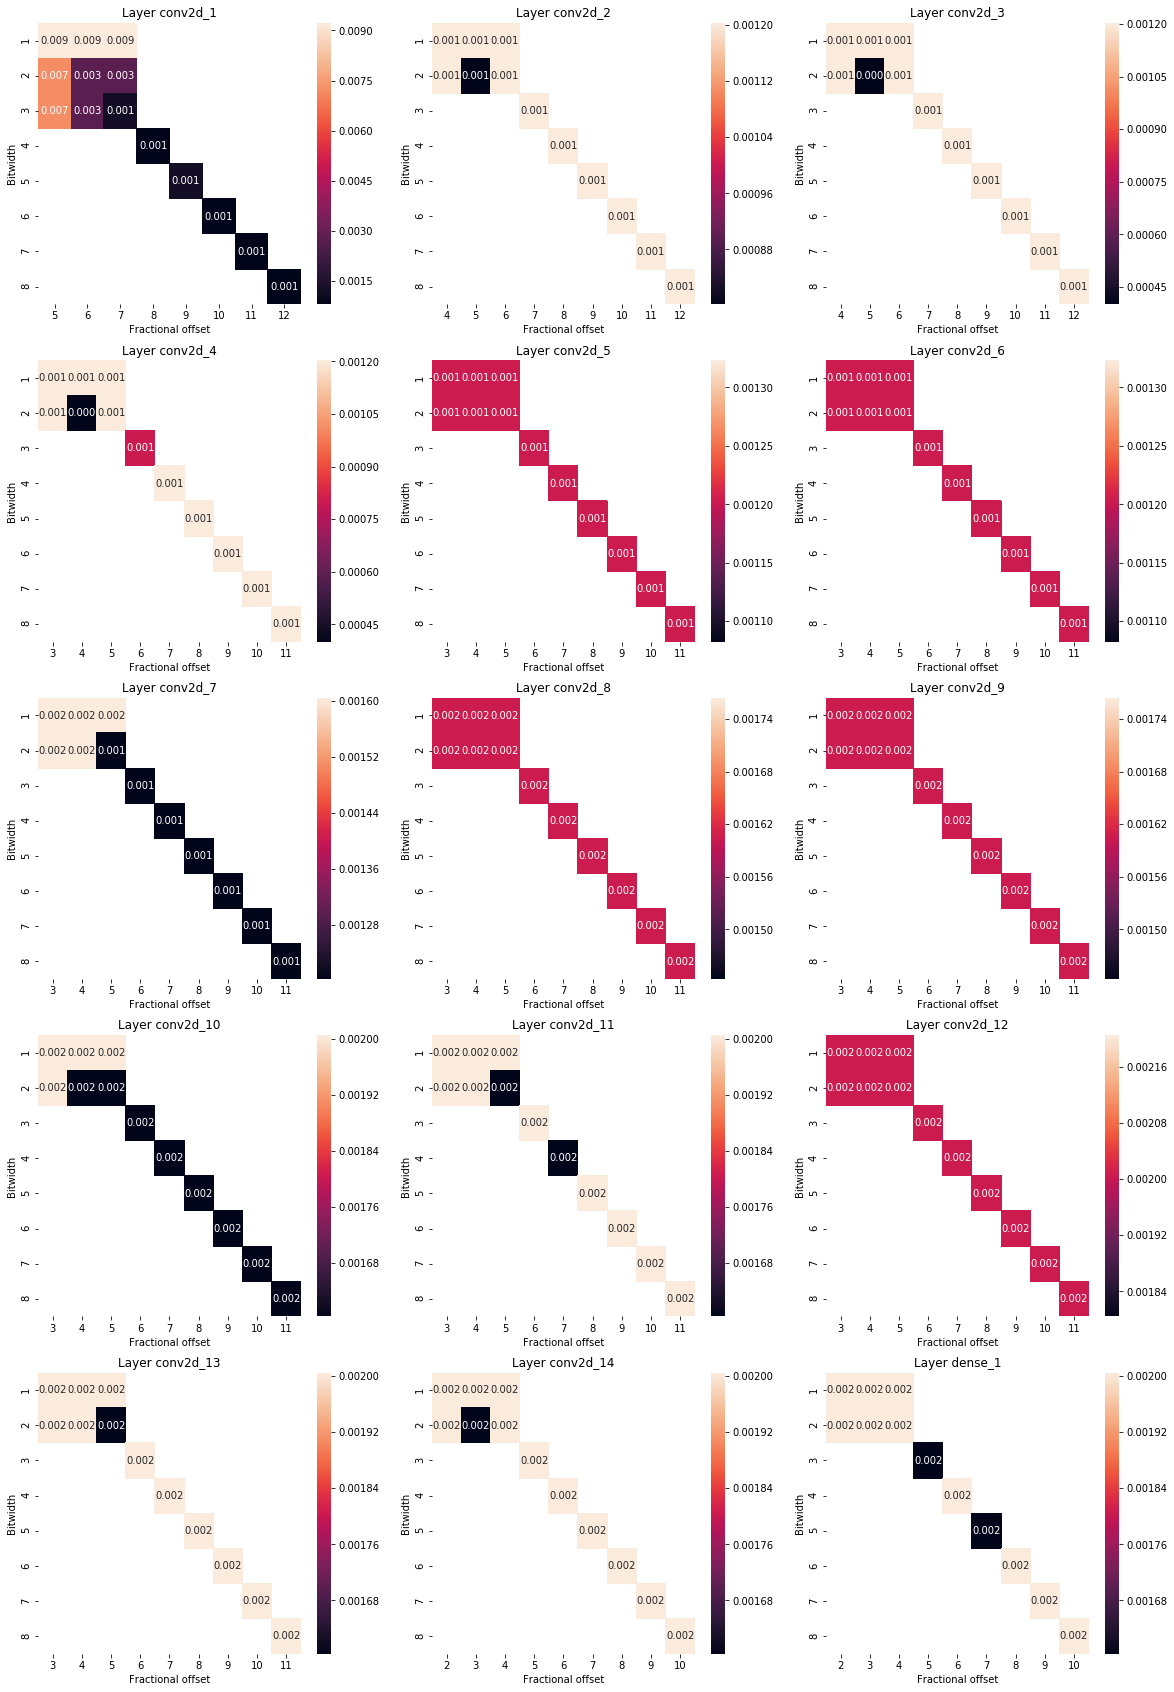

In [56]:
b_scores, opt_params_biases, acc_drop_b = opts.run(acc_drop_config, 'biases', start_bw = 8)
opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [57]:
opts.quant_evaluator.quant_params

QuantizationParameters(weights={'conv2d_1': (4, 5), 'conv2d_2': (3, 5), 'conv2d_3': (2, 3), 'conv2d_4': (2, 4), 'conv2d_5': (3, 4), 'conv2d_6': (3, 4), 'conv2d_7': (3, 5), 'conv2d_8': (2, 4), 'conv2d_9': (2, 4), 'conv2d_10': (3, 5), 'conv2d_11': (2, 4), 'conv2d_12': (2, 4), 'conv2d_13': (3, 5), 'conv2d_14': (2, 4), 'dense_1': (2, 3)}, biases={'conv2d_1': (3, 7), 'conv2d_2': (1, 5), 'conv2d_3': (1, 5), 'conv2d_4': (1, 4), 'conv2d_5': (1, 3), 'conv2d_6': (1, 3), 'conv2d_7': (1, 4), 'conv2d_8': (1, 3), 'conv2d_9': (1, 3), 'conv2d_10': (1, 4), 'conv2d_11': (1, 4), 'conv2d_12': (1, 3), 'conv2d_13': (1, 4), 'conv2d_14': (1, 3), 'dense_1': (1, 2)}, activations={})

#### Activations

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 7], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 7], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 7], 'conv2d_13': [12, 6], 'conv2d_14': [12, 7], 'dense_1': [12, 6]}
Quantizing layer conv2d_1
Global opt: (5, 5) Local opt: (6, 6) Performance diff: 0.002005
Chosen:  (6, 6)
After quantizing activations of layer conv2d_1 | Measured accuracy drop 0.003208 | Acceptable accuracy drop: 0.005333
Quantizing layer conv2d_2
Global opt: (4, 2) Local opt: (5, 3) Performance diff: 0.001203
Chosen:  (4, 2)
After quantizing activations of layer conv2d_2 | Measured accuracy drop 0.004010 | Acceptable accuracy drop: 0.005667
Quantizing layer conv2d_3
Global opt: (4, 0) Local opt: (4, 0) Performance diff: 0.000000
Chosen:  (4, 0)
After quantizing activations of layer conv2d_3 | Measured accuracy drop 0.004411 | Acceptable accuracy drop: 0.006000
Quantiz

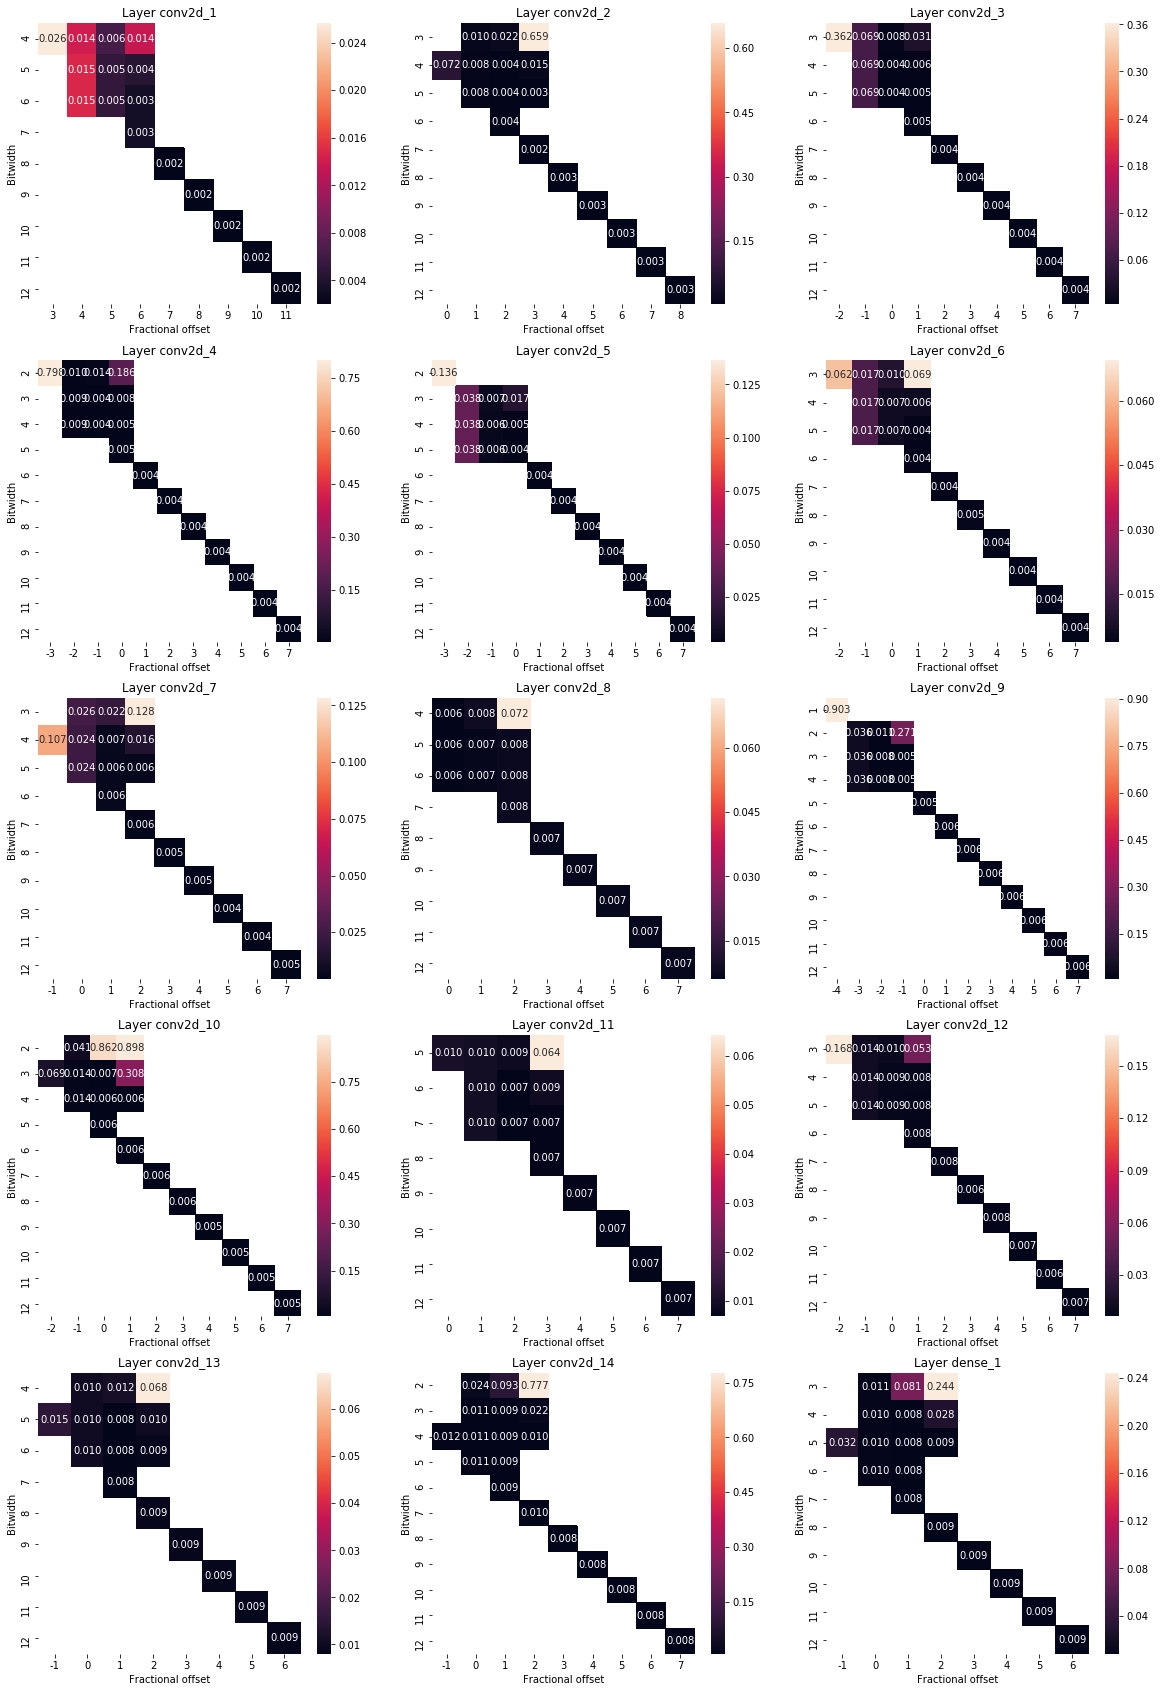

In [58]:
acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names), total_acc_drop) for i in range(1, len(layer_names) + 1)
}

a_scores, opt_params_act, acc_drop_a = opts.run(acc_drop_config, 'activations', start_bw = 12)
opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [59]:
float_model_a4 = []
fxp_model_a4 = []

for i in range(4):
    float_model = model_data.Model(name, test_data[i], model=model_arch.get_float_model())
    float_model_a4.append(float_model.evaluate_accuracy()[1])

    fxp_model = fxp_quantize.fix_model_quantization(model_arch, name, test_data[i], opts.quant_evaluator.quant_params)
    fxp_model_a4.append(fxp_model.evaluate_accuracy()[1])

In [60]:
float_model_a4, fxp_model_a4

([0.9912, 0.994, 0.9972, 0.9976], [0.964, 0.964, 0.9856, 0.9892])

<BarContainer object of 4 artists>

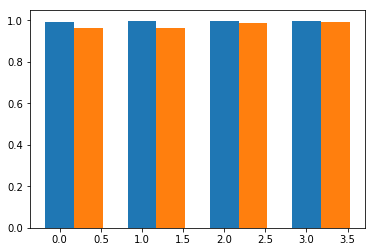

In [61]:
plt.figure()
plt.bar(np.arange(4), float_model_a4, width=0.35)
plt.bar(np.arange(4) + 0.35, fxp_model_a4, width=0.35)

In [62]:
with open(output_path + 'opt_params.p', 'rb') as f:
    opt_params = pickle.load(f)

In [63]:
bws_small = {}
bws_original = {}
qp = opts.quant_evaluator.quant_params._asdict()
for k in qp:
    bws_small[k] = [qp[k][layer][0] for layer in qp[k]]
    bws_original[k] = [opt_params[k][layer][0] for layer in opt_params[k]]

In [64]:
bws_small # (2500 samples)

{'weights': [4, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [6, 4, 4, 3, 5, 5, 4, 4, 4, 3, 6, 4, 5, 3, 4]}

In [65]:
bws_original # 10000 samples

{'weights': [5, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2],
 'biases': [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'activations': [6, 4, 4, 4, 3, 5, 5, 3, 4, 4, 3, 3, 3, 3, 5]}

In [66]:
memory_consumption = evaluation_metrics.evaluate_memory_consumption(fxp_model.model, layer_names, opts.quant_evaluator.quant_params._asdict())
for k in memory_consumption:
    print(f'Memory consumption of {k} (KB): {memory_consumption[k]}')

Memory consumption of weights (KB): 93.671875
Memory consumption of biases (KB): 0.094970703125
Memory consumption of activations (KB): 69.5673828125
